## List of Python packages 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio
* finRL

## Import Dependencies

In [27]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from support_files.yahoo_downloader import YahooDownloader
from support_files.preprocessor import FeatureEngineer, data_split
from support_files.data_processor_copy import DataProcessor
import support_files.config as config
import support_files.config_tickers as config_tickers
from support_files.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from finrl.main import check_and_make_directories
from support_files.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
from support_files.env_no_RC import StockTradingEnv as StockTradingEnv_original
from stable_baselines3.common.logger import configure
import os
from mod_env_new import StockTradingEnv # with risk controller
from support_files.models import DRLAgent
from support_files.mvo_baseline import *
from pprint import pprint
import sys
sys.path.append("../FinRL")
import itertools

In [2]:
# creating folders to store logs
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

## Input options (only this needs to be changed for different experiments):

In [3]:
ds = "dow"
train_gym_option = "with_RC"# "original" # or "with_RC"
test_gym_option = "original"# "original" # or "with_RC"

if_using_a2c = False
if_using_ddpg = False
if_using_ppo = False
if_using_td3 = False
if_using_sac = True

train_time_steps = 10000

## Dataset details


In [4]:
if ds == "snp":
    TRAIN_START_DATE = '2015-01-01'
    TRAIN_END_DATE = '2019-10-01'
    TRADE_START_DATE = '2021-01-01'
    TRADE_END_DATE = '2022-10-31'
    index = ["^GSPC"]
    ticker_list = config_tickers.SP_500_TICKER[::50]
else:
    TRAIN_START_DATE = '2010-01-01'
    TRAIN_END_DATE = '2021-10-01'
    TRADE_START_DATE = '2021-10-01'
    TRADE_END_DATE = '2023-03-01'
    index = ["^DJI"]
    ticker_list = config_tickers.DOW_30_TICKER

In [26]:
config_tickers.SP_500_TICKER[::50]

['A', 'ARNC', 'CL', 'DVA', 'GILD', 'IR', 'MAR', 'NWS', 'ROST', 'UAL', 'ZTS']

In [5]:
df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = ticker_list).fetch_data()

set_index = YahooDownloader(start_date = TRADE_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = index).fetch_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Shape of DataFrame:  (97013, 8)
Shape of DataFrame:  (354, 8)


In [6]:
# # for label, df in set_index.items():
# #     if df is not None:
# set_index.to_csv('SNP.csv', index=True)

# Preprocess Data
Adding technical indicators 

In [7]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = INDICATORS,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators


[*********************100%%**********************]  1 of 1 completed


Shape of DataFrame:  (3310, 8)
Successfully added vix
Successfully added turbulence index


In [8]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))
processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])
processed_full = processed_full.fillna(0)

# OpenAI Gym trading environment

In [9]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,
    "make_plots": True 
}

85753
10237
Stock Dimension: 29, State Space: 291


In [10]:
mvo_df = processed_full.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]
MVO_result = mvo_opt(mvo_df, stock_dimension)
# Reset the index of the DataFrame to make the first column 'date'
MVO_result = MVO_result.reset_index()
# Rename the new column if it doesn't automatically name it 'date'
MVO_result.rename(columns={'index': 'date'}, inplace=True)
MVO_result['date'] = pd.to_datetime(MVO_result['date'])

## Environments for Training and Testing

In [11]:
if train_gym_option == "with_RC":
    e_train_gym = StockTradingEnv(df = train, **env_kwargs)
else:
    e_train_gym = StockTradingEnv_original(df = train, **env_kwargs)

env_train, _ = e_train_gym.get_sb_env()
# print(type(env_train))

if test_gym_option == "with_RC":
    e_trade_gym = StockTradingEnv(df = trade,turbulence_threshold = None, risk_indicator_col='vix', **env_kwargs)
else:
    e_trade_gym = StockTradingEnv_original(df = trade,turbulence_threshold = None, risk_indicator_col='vix', **env_kwargs)


# Training DRL Agents
from Stablebaselines3

### Agent Training: 5 algorithms (A2C, DDPG, PPO, TD3, SAC)


### Agent 1: A2C


In [12]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

if if_using_a2c:
  # set up logger
  tmp_path = RESULTS_DIR + '/a2c'
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_a2c.set_logger(new_logger_a2c)
  # Save the trained model
  model_a2c.save(RESULTS_DIR + '/a2c/trained_model_a2c.zip')

try:
    trained_a2c = agent.train_model(
        model=model_a2c, 
        tb_log_name='a2c',
        total_timesteps=train_time_steps #, #,
    ) if if_using_a2c else None
except Exception as e:
    print("Failed to train due to:", e)

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device


### Agent 2: DDPG

In [13]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

if if_using_ddpg:
  # set up logger
  tmp_path = RESULTS_DIR + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ddpg.set_logger(new_logger_ddpg)
  # Save the trained model
  model_ddpg.save(tmp_path + '/trained_model_ddpg.zip')

try:
    trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=train_time_steps) if if_using_ddpg else None
except Exception as e:
    print("Failed to train due to:", e)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device


### Agent 3: PPO

In [14]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

if if_using_ppo:
  # set up logger
  tmp_path = RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)
  # Save the trained model
  model_ppo.save(tmp_path + '/trained_model_ppo.zip')

try:
    trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=train_time_steps) if if_using_ppo else None
except Exception as e:
    print("Failed to train due to:", e)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device


### Agent 4: TD3

In [15]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

if if_using_td3:
  # set up logger
  tmp_path = RESULTS_DIR + '/td3'
  new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_td3.set_logger(new_logger_td3)
  # Save the trained model
  model_td3.save(tmp_path + '/trained_model_td3.zip')

try:
  trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=train_time_steps) if if_using_td3 else None
except Exception as e:
    print("Failed to train due to:", e)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device


c:\Users\eshik\Documents\DL_project\finRLvenv\lib\site-packages\stable_baselines3\common\buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 2.45GB > 0.46GB
  warnings.warn(


### Agent 5: SAC

In [16]:
env_train, _ = e_train_gym.get_sb_env()
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

if if_using_sac:
  # set up logger
  tmp_path = RESULTS_DIR + '/sac'
  new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_sac.set_logger(new_logger_sac)
  # Save the trained model
  model_sac.save(tmp_path + '/trained_model_sac.zip')
  
try:
  trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=train_time_steps) if if_using_sac else None
except Exception as e:
    print("Failed to train due to:", e)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device
Logging to results/sac
No NaNs or Infs found in the matrix. No conversion applied.
non psd
(0, 1, 0.0)


c:\Users\eshik\Documents\DL_project\finRLvenv\lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\eshik\Documents\DL_project\finRLvenv\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\eshik\Documents\DL_project\finRLvenv\lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\eshik\Documents\DL_project\finRLvenv\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\eshik\Documents\DL_project\finRLvenv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\eshik\Documents\DL_project\finR

No NaNs or Infs found in the matrix. No conversion applied.
non psd
(0, 2, 0.0)
No NaNs or Infs found in the matrix. No conversion applied.
non psd
(0, 3, 0.0)
No NaNs or Infs found in the matrix. No conversion applied.
non psd
(0, 4, 0.0)
No NaNs or Infs found in the matrix. No conversion applied.
non psd
(0, 5, 0.0)
No NaNs or Infs found in the matrix. No conversion applied.
non psd
(0, 6, 0.0)
No NaNs or Infs found in the matrix. No conversion applied.
non psd
(0, 7, 0.0)
No NaNs or Infs found in the matrix. No conversion applied.
non psd
(0, 8, 0.0)
No NaNs or Infs found in the matrix. No conversion applied.
non psd
(0, 9, 0.0)
No NaNs or Infs found in the matrix. No conversion applied.
non psd
(0, 10, 0.0)
No NaNs or Infs found in the matrix. No conversion applied.
non psd
(0, 11, 0.0)
No NaNs or Infs found in the matrix. No conversion applied.
non psd
(0, 12, 0.0)
No NaNs or Infs found in the matrix. No conversion applied.
non psd
(0, 13, 0.0)
No NaNs or Infs found in the matrix.

c:\Users\eshik\Documents\DL_project\finRLvenv\lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\eshik\Documents\DL_project\finRLvenv\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\eshik\Documents\DL_project\finRLvenv\lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\eshik\Documents\DL_project\finRLvenv\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\eshik\Documents\DL_project\finRLvenv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\eshik\Documents\DL_project\finR

No NaNs or Infs found in the matrix. No conversion applied.
non psd
(0, 2959, 0.0)
No NaNs or Infs found in the matrix. No conversion applied.
non psd
(0, 2960, 0.0)
No NaNs or Infs found in the matrix. No conversion applied.
non psd
(0, 2961, 0.0)
No NaNs or Infs found in the matrix. No conversion applied.
non psd
(0, 2962, 0.0)
No NaNs or Infs found in the matrix. No conversion applied.
non psd
(0, 2963, 0.0)
No NaNs or Infs found in the matrix. No conversion applied.
non psd
(0, 2964, 0.0)
No NaNs or Infs found in the matrix. No conversion applied.
non psd
(0, 2965, 0.0)
No NaNs or Infs found in the matrix. No conversion applied.
non psd
(0, 2966, 0.0)
No NaNs or Infs found in the matrix. No conversion applied.
non psd
(0, 2967, 0.0)
No NaNs or Infs found in the matrix. No conversion applied.
non psd
(0, 2968, 0.0)
No NaNs or Infs found in the matrix. No conversion applied.
non psd
(0, 2969, 0.0)
No NaNs or Infs found in the matrix. No conversion applied.
non psd
(0, 2970, 0.0)
No N

c:\Users\eshik\Documents\DL_project\finRLvenv\lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\eshik\Documents\DL_project\finRLvenv\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\eshik\Documents\DL_project\finRLvenv\lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\eshik\Documents\DL_project\finRLvenv\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\eshik\Documents\DL_project\finRLvenv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No NaNs or Infs found in the matrix. No conversion applied.
non psd
(1, 5916, 0.016903313049357674)
No NaNs or Infs found in the matrix. No conversion applied.
non psd
(1, 5917, 0.01690045631232043)
No NaNs or Infs found in the matrix. No conversion applied.
non psd
(1, 5918, 0.016897600540723215)
No NaNs or Infs found in the matrix. No conversion applied.
non psd
(1, 5919, 0.0168947457340767)
No NaNs or Infs found in the matrix. No conversion applied.
non psd
(1, 5920, 0.016891891891891893)
No NaNs or Infs found in the matrix. No conversion applied.
non psd
(1, 5921, 0.01688903901368012)
No NaNs or Infs found in the matrix. No conversion applied.
non psd
(1, 5922, 0.016886187098953058)
No NaNs or Infs found in the matrix. No conversion applied.
non psd
(1, 5923, 0.01688333614722269)
No NaNs or Infs found in the matrix. No conversion applied.
non psd
(1, 5924, 0.01688048615800135)
No NaNs or Infs found in the matrix. No conversion applied.
non psd
(1, 5925, 0.016877637130801686)
No NaN

c:\Users\eshik\Documents\DL_project\finRLvenv\lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\eshik\Documents\DL_project\finRLvenv\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\eshik\Documents\DL_project\finRLvenv\lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\eshik\Documents\DL_project\finRLvenv\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\eshik\Documents\DL_project\finRLvenv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\eshik\Documents\DL_project\finR

No NaNs or Infs found in the matrix. No conversion applied.
non psd
(1, 8873, 0.011270145384875464)
No NaNs or Infs found in the matrix. No conversion applied.
non psd
(1, 8874, 0.01126887536623845)
No NaNs or Infs found in the matrix. No conversion applied.
non psd
(1, 8875, 0.011267605633802818)
No NaNs or Infs found in the matrix. No conversion applied.
non psd
(1, 8876, 0.011266336187471835)
No NaNs or Infs found in the matrix. No conversion applied.
non psd
(1, 8877, 0.011265067027148813)
No NaNs or Infs found in the matrix. No conversion applied.
non psd
(1, 8878, 0.011263798152737103)
No NaNs or Infs found in the matrix. No conversion applied.
non psd
(1, 8879, 0.011262529564140106)
No NaNs or Infs found in the matrix. No conversion applied.
non psd
(1, 8880, 0.01126126126126126)
No NaNs or Infs found in the matrix. No conversion applied.
non psd
(1, 8881, 0.011259993244004054)
No NaNs or Infs found in the matrix. No conversion applied.
non psd
(1, 8882, 0.01125872551227201)
No 

## Testing

Assume that the initial capital is $1,000,000.

In [17]:
# %matplotlib inline
# def plot_attributes(df, attributes):
#     # Ensure the date column is datetime type for better plotting
#     df['date'] = pd.to_datetime(df['date'])
    
#     # Determine the number of subplots needed
#     n_attributes = len(attributes)
#     plt.figure(figsize=(10, 5 * n_attributes))
    
#     # Plot each attribute in a separate subplot
#     for i, attribute in enumerate(attributes):
#         plt.subplot(n_attributes, 1, i + 1)  # Create a subplot for each attribute
#         for ticker in df['tic'].unique():
#             # Filter data for each ticker
#             stock_data = df[df['tic'] == ticker]
#             plt.plot(stock_data['date'], stock_data[attribute], label=f'{ticker}')

#         plt.title(f'{attribute.title()} Over Time')
#         plt.xlabel('Date')
#         plt.ylabel(attribute.title())
#         plt.legend()
#         plt.grid(True)
#         plt.savefig(f'{attribute}_over_time.png')
    
#     plt.tight_layout()
#     plt.show()

# # Attributes you want to plot
# attributes = ['close', 'close', 'volume', 'macd', 'rsi_30']

# # Call the function to plot data
# plot_attributes(trade, attributes)

In [18]:
if if_using_a2c: 
    m = trained_a2c
    df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
        model=m, 
        environment = e_trade_gym)#if if_using_a2c else None, None
else:
    df_account_value_a2c, df_actions_a2c = None, None

if if_using_ddpg: 
    m = trained_ddpg
    df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
        model=m, 
        environment = e_trade_gym)
else: 
    df_account_value_ddpg, df_actions_ddpg = None, None
    

if if_using_ppo:
    m = trained_ppo
    df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
        model=m, 
        environment = e_trade_gym)#if if_using_ppo else None, None
else:
    df_account_value_ppo, df_actions_ppo = None, None

if if_using_td3:
    m = trained_td3
    df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
        model=m, 
        environment = e_trade_gym) #else None, None
else: 
    df_account_value_td3, df_actions_td3 = None, None

if if_using_sac: 
    m = trained_sac
    df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
        model=m, 
        environment = e_trade_gym) #if if_using_sac else None, None
else:
    df_account_value_sac, df_actions_sac = None, None


hit end!


## Plots and backtesting


In [19]:
dataframes = {
    'df_a2c': df_account_value_a2c,
    'df_sac': df_account_value_sac,
    'df_ddpg': df_account_value_ddpg,
    'df_ppo': df_account_value_ppo,
    'df_td3': df_account_value_td3,
    'df_actions_a2c': df_actions_a2c,  # assuming action DataFrames similarly named
    'df_actions_sac': df_actions_sac,
    'df_actions_ddpg': df_actions_ddpg,
    'df_actions_ppo': df_actions_ppo,
    'df_actions_td3': df_actions_td3,
    'df_MVO': MVO_result
}

for label, df in dataframes.items():
    if df is not None:
        df.to_csv(f'{label+train_gym_option}.csv', index=True)
        if label in ['df_a2c', 'df_sac', 'df_ddpg', 'df_ppo', 'df_td3']:
            print(f"{label} stats ---------------")
            stats = backtest_stats(df, value_col_name = 'account_value')

df_sac stats ---------------
Annual return         -0.035969
Cumulative returns    -0.050019
Annual volatility      0.191558
Sharpe ratio          -0.096123
Calmar ratio          -0.145326
Stability              0.257036
Max drawdown          -0.247503
Omega ratio            0.984012
Sortino ratio         -0.133172
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.884839
Daily value at risk   -0.024207
dtype: float64


In [20]:
stats = backtest_stats(MVO_result, value_col_name = 'Mean Var')

Annual return         -0.067169
Cumulative returns    -0.088541
Annual volatility      0.236879
Sharpe ratio          -0.176089
Calmar ratio          -0.261627
Stability              0.422562
Max drawdown          -0.256738
Omega ratio            0.971373
Sortino ratio         -0.244202
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.912552
Daily value at risk   -0.030009
dtype: float64


In [21]:
print("==============Get Index Stats===========")
df_dji= get_baseline(
        ticker=index[0], 
        start = TRADE_START_DATE,
        end = TRADE_END_DATE)
stats = backtest_stats(df_dji, value_col_name = 'close')

df_dji['close'] = df_dji['close'].astype(float)
df_dji = pd.DataFrame({
    'date': pd.to_datetime(df_dji['date']),
    'account_value': df_dji['close'] / df_dji['close'].iloc[0] * env_kwargs["initial_amount"]  
})
df_dji.to_csv("df_dji.csv")
df_dji.set_index('date', inplace=True)
df_dji.to_csv("df_dji+.csv")

==============Get Index Stats===========


[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (354, 8)
Annual return         -0.034876
Cumulative returns    -0.048644
Annual volatility      0.181612
Sharpe ratio          -0.105351
Calmar ratio          -0.158953
Stability              0.280983
Max drawdown          -0.219408
Omega ratio            0.982546
Sortino ratio         -0.146974
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.970602
Daily value at risk   -0.022957
dtype: float64


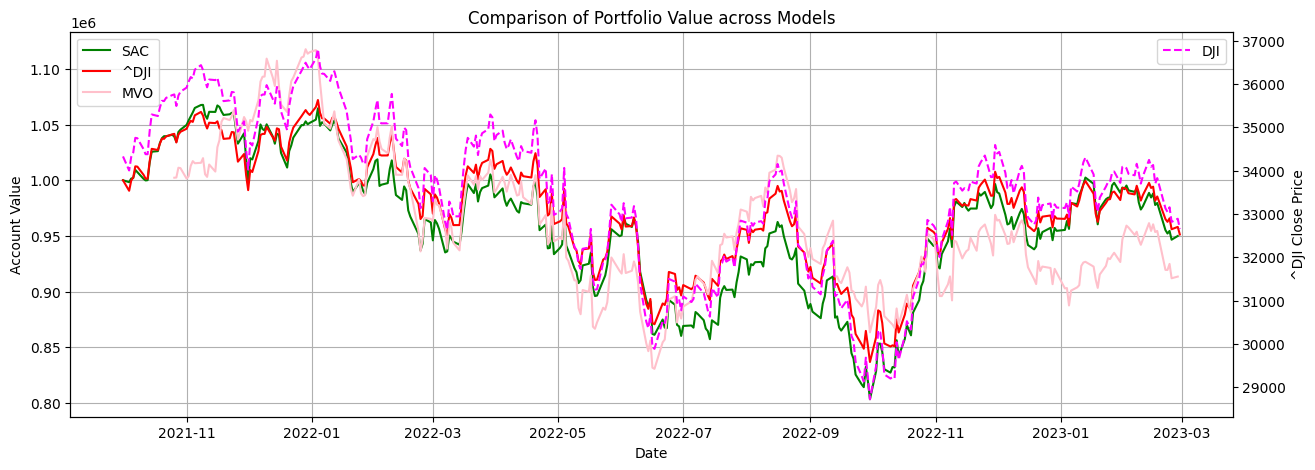

In [22]:
set_index['date'] = pd.to_datetime(set_index['date'])
%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 5)

fig, ax1 = plt.subplots()

# Plot each dataset if it is not None
if df_account_value_a2c is not None:
    df_account_value_a2c[df_account_value_a2c.columns[0]] = pd.to_datetime(df_account_value_a2c[df_account_value_a2c.columns[0]])
    ax1.plot(df_account_value_a2c[df_account_value_a2c.columns[0]], df_account_value_a2c[df_account_value_a2c.columns[1]], label='A2C', color='blue')

if df_account_value_ddpg is not None:
    df_account_value_ddpg[df_account_value_ddpg.columns[0]] = pd.to_datetime(df_account_value_ddpg[df_account_value_ddpg.columns[0]])
    ax1.plot(df_account_value_ddpg[df_account_value_ddpg.columns[0]], df_account_value_ddpg[df_account_value_ddpg.columns[1]], label='DDPG', color='orange')

if df_account_value_ppo is not None:
    df_account_value_ppo[df_account_value_ppo.columns[0]] = pd.to_datetime(df_account_value_ppo[df_account_value_ppo.columns[0]])
    ax1.plot(df_account_value_ppo[df_account_value_ppo.columns[0]], df_account_value_ppo[df_account_value_ppo.columns[1]], label='PPO', color='purple')

if df_account_value_td3 is not None:
    df_account_value_td3[df_account_value_td3.columns[0]] = pd.to_datetime(df_account_value_td3[df_account_value_td3.columns[0]])
    ax1.plot(df_account_value_td3[df_account_value_td3.columns[0]], df_account_value_td3[df_account_value_td3.columns[1]], label='TD3', color='black')

if df_account_value_sac is not None:
    df_account_value_sac[df_account_value_sac.columns[0]] = pd.to_datetime(df_account_value_sac[df_account_value_sac.columns[0]])
    ax1.plot(df_account_value_sac[df_account_value_sac.columns[0]], df_account_value_sac[df_account_value_sac.columns[1]], label='SAC', color='green')

ax1.plot(df_dji.index, df_dji['account_value'], label=f'{index[0]}', color='red')
ax1.plot(MVO_result['date'], MVO_result['Mean Var'], label='MVO', color='pink')

# Setting labels and titles
ax1.set_xlabel('Date')
ax1.set_ylabel('Account Value')
ax1.legend(loc='upper left')
ax1.grid(True)

ax2 = ax1.twinx()
if set_index is not None:
    ax2.plot(set_index['date'], set_index['close'], '--', label='S&P 500' if ds=="snp" else 'DJI', color='magenta')
    ax2.set_ylabel(f'{index[0]} Close Price')
    ax2.legend(loc='upper right')

# Title for the figure
plt.title(f'Comparison of Portfolio Value across Models')

plt.show()


In [23]:
def calculate_rolling_risk(df, column_name='account_value', window=3):
    df['daily_return'] = df[column_name].pct_change()
    df['rolling_risk'] = df['daily_return'].rolling(window).std()
    return df

# Apply the function to each DataFrame if they exist
if df_account_value_a2c is not None:
    df_account_value_a2c = calculate_rolling_risk(df_account_value_a2c)
if df_account_value_sac is not None:
    df_account_value_sac = calculate_rolling_risk(df_account_value_sac)
if df_account_value_ddpg is not None:
    df_account_value_ddpg = calculate_rolling_risk(df_account_value_ddpg)
if df_account_value_ppo is not None:
    df_account_value_ppo = calculate_rolling_risk(df_account_value_ppo)
if df_account_value_td3 is not None:
    df_account_value_td3 = calculate_rolling_risk(df_account_value_td3)
if df_dji is not None:
    df_dji = calculate_rolling_risk(df_dji, 'account_value')  
if MVO_result is not None:
    MVO_result = calculate_rolling_risk(MVO_result, 'Mean Var') 



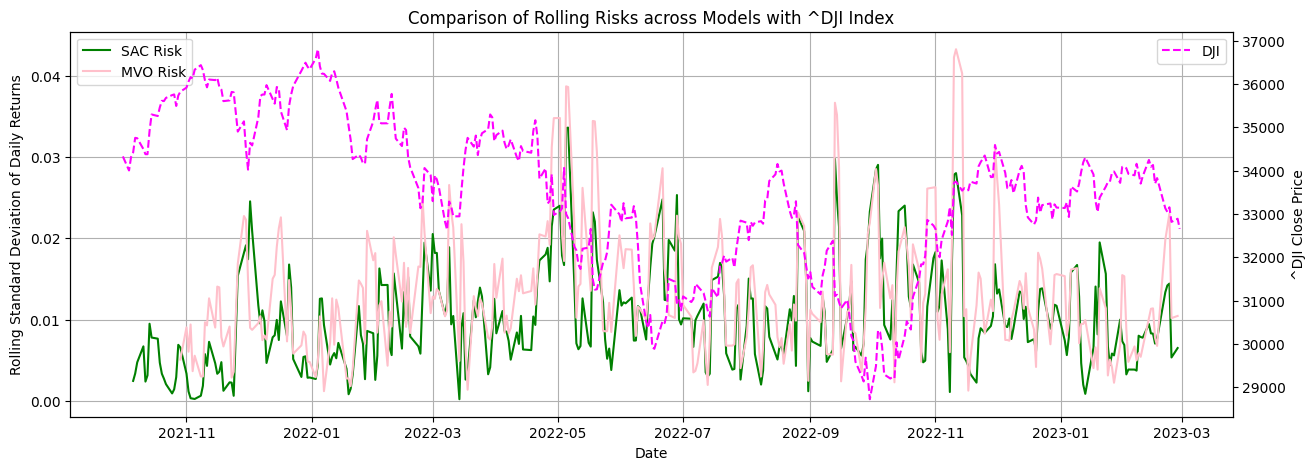

In [24]:
%matplotlib inline

# Define the figure and primary axis
fig, ax1 = plt.subplots(figsize=(15, 5))

# Plot rolling risks for each model on the primary axis
models = {
    'A2C': (df_account_value_a2c, 'blue'),
    'SAC': (df_account_value_sac, 'green'),
    'DDPG': (df_account_value_ddpg, 'orange'),
    'PPO': (df_account_value_ppo, 'purple'),
    'TD3': (df_account_value_td3, 'black'),
    'DJI': (df_dji, 'red'),
    'MVO': (MVO_result, 'pink')
}
for model, (df, color) in models.items():
    if df is not None and 'rolling_risk' in df.columns and 'date' in df.columns:
        ax1.plot(df['date'], df['rolling_risk'], label=f'{model} Risk', color=color)

ax1.set_xlabel('Date')
ax1.set_ylabel('Rolling Standard Deviation of Daily Returns')
ax1.legend(loc='upper left')
ax1.grid(True)

# Set up the secondary axis
ax2 = ax1.twinx()
if set_index is not None:
    ax2.plot(set_index['date'], set_index['close'], '--', label='S&P 500' if ds=="snp" else 'DJI', color='magenta')
    ax2.set_ylabel(f'{index[0]} Close Price')
    ax2.legend(loc='upper right')

# Title for the figure
plt.title(f'Comparison of Rolling Risks across Models with {index[0]} Index')
plt.show()